# Playing Blackjack with Reinforcement Learning
##### By Jonathan L. Moran (jo6155mo-s@student.lu.se)
From the EDAN95 - Applied Machine Learning course given at Lunds Tekniska Högskola (LTH) | Ht2 2019.

## Objectives
*  Understand the Blackjack card game
*  Formulate the game as an episodic finite MDP
*  Define a policy and find its state-value function using a MC approach
*  Find the optimal policy using a MC e-greedy control algorithm

## Background and Tools

### Blackjack introduction

#### Goal
*  Obtain cards whose numerical value is as great as possible without exceeding 21.

#### Rules
*  2 Players (dealer vs. player)
*  The player closest to the goal wins
*  If a player exceeds 21, they lose (_bust_)
*  If both players exceed 21, it is a _draw_
*  Jack/Queen/King = 10 pts, Ace = 1 pt (11 pts if _usable_)
*  Sampling with replacement (infinite deck)

#### Gameplay
*  Both players recieve two cards at the start of the game
*  One of the dealer's cards is face down at the start of the game
*  If the player draws an ace, it is said to be _usable_ if they can count it as 11 without going bust



### Problem formulation

#### Episode
Each game of blackjack is an _episode_. At the end of each episode, a _reward_ is given. The value of this reward is defined as `+1.0` for a _win_, `-1.0` for a _lose_ and `0.0` for a _draw_.

#### State representation
At the start of each episode, the player (and concequently, the algorithm we are designing) only knows three pieces of information: the value of the dealer's showing card, the player's current score (the sum of the cards in hand), and whether or not they hold a usable ace.

#### Action
At each turn, the player has only two possible actions: _hit_ or _stick_. If the player has 21 immediately (an ace and a 10-card), it is called a _natural_. The player then wins unless the dealer also has a natural, in which case the game is a draw.

### Monte Carlo approach

#### MC Prediction
The goal of the MC prediction problem is to learn the state-value function for a given policy. This is done by simulating many blackjack games using the policy and averaging the returns following each state.

#### MC Control
The goal of the MC control problem is to determine the _optimal policy_ (a state-action pair) that maximises the reward function. This is done using an $\epsilon$-greedy approach, meaning that the agent chooses with probability $1-\epsilon$ the action that has the maximal estimated action value the majority of the time, but infrequently selects an action at random with probability $\epsilon$.

#### Parameters
*  State: player's current total, dealer's showing card.
*  Action: draw another card (_hit_), end your turn (_stick_).
*  Reward: win (+1), lose (-1), draw (0).

#### Policy
*  Player: _stick_ if sum is 20 or 21, else _hit_ (only used for MC prediction).
*  Dealer: _stick_ if sum is greater than or equal to 17, else _hit_.

### Tools

#### Literature
*  Sutton, R. S., & Barto, A. G. (2018). _Reinforcement learning: An introduction_, 91-103. MIT press.

#### Resources
*  Jareth Moyo (2020). _Lecture 12: Playing Blackjack with Monte Carlo_. https://www.youtube.com/watch?v=3686U57JnLs.

#### Programming
*  OpenAI gym (2016). _blackjack.py_. https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py.
*  Britz, D (2018). _reinforcement-learning_. https://github.com/dennybritz/reinforcement-learning.

## 1. Blackjack Playground

### Blackjack

In [ ]:
### From `blackjack.py` in V.K.'s `RL Exercise`
# Adapted from OpenAI's gym `blackjack.py` with Casino Rules (natural) flag
# Credit: https://github.com/volkerkrueger/edan95/blob/master/labs/blackjack.py

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return int((a > b)) - int((a < b))

def draw_card(np_random):
    return np_random.choice(deck)

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
            return sum(hand) + 10
    return sum(hand)

def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21

def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)

def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    https://webdocs.cs.ualberta.ca/~sutton/book/the-book.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self._seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self._reset()
        self.nA = 2       # Number of actions

    def reset(self):
        return self._reset()

    def step(self, action):
        return self._step(action)

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        assert self.action_space.contains(action)
        if action:          # Hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:               # Stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def _reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        # Auto-draw another card if the score is less than 12
        while sum_hand(self.player) < 12:
            self.player.append(draw_card(self.np_random))
        return self._get_obs()

if __name__ == '__main__':
    # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
    deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

### Blackjack simulation environment

In [ ]:
### From `BlackjackPlayground.ipynb` in V.K.'s `RL Exercise`
# Credit: github.com/dennybritz/reinforcement-learning/MC/

In [ ]:
import numpy as np
import sys

def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    return 0 if score >= 20 else 1

if __name__ == '__main__':
    env = BlackjackEnv()
    for i_episode in range(20):
        observation = env.reset()
        for t in range(100):
            print_observation(observation)
            action = strategy(observation)
            print("Taking action: {}".format( ["Stick", "Hit"][action]))
            observation, reward, done, _ = env.step(action)
            if done:
                print_observation(observation)
                print("Game end. Reward: {}\n".format(float(reward)))
                break  
    
    print(observation)
    observation = env.reset()
    print_observation(observation)

Player Score: 15 (Usable Ace: False), Dealer Score: 1
Taking action: Hit
Player Score: 25 (Usable Ace: False), Dealer Score: 1
Game end. Reward: -1.0

Player Score: 13 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 15 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 25 (Usable Ace: False), Dealer Score: 10
Game end. Reward: -1.0

Player Score: 21 (Usable Ace: True), Dealer Score: 4
Taking action: Stick
Player Score: 21 (Usable Ace: True), Dealer Score: 4
Game end. Reward: 1.0

Player Score: 15 (Usable Ace: False), Dealer Score: 7
Taking action: Hit
Player Score: 23 (Usable Ace: False), Dealer Score: 7
Game end. Reward: -1.0

Player Score: 20 (Usable Ace: False), Dealer Score: 2
Taking action: Stick
Player Score: 20 (Usable Ace: False), Dealer Score: 2
Game end. Reward: 1.0

Player Score: 19 (Usable Ace: True), Dealer Score: 10
Taking action: Hit
Player Score: 19 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 21 (Usab

The Player has only two options: _hit_ (`1`) or _stick_ (`0`).

In [ ]:
env.action_space

Discrete(2)

Each state is stored in a tuple in the format: 

`(Player score, Dealer's visible card, usable/no usable ace)`

In [ ]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

Some notes:
*  Each state representation (an `observation`) is a tuple `(x1, x2, x3)` where `x1` is the current sum of player, `x2` is the value of the dealer's showing card, and `x3` is a boolean indicating whether or not the player is holding a usable ace
*  The player policy (`strategy` function) is defined to be _hit_ unless player score is 20 or greater (then _stick_)
*  The dealer policy is defined to be _hit_ unless dealer score is 17 or greater
*  An ace (initially 1) is said to be usable (11) if player's current sum + 10 is less than or equal to 21

## 2. Monte Carlo Blackjack Strategy Optimisation

In [ ]:
### From `plotting.py` in V.K.'s `RL Exercise`
# Credit: github.com/dennybritz/reinforcement-learning/lib/plotting.py

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())
    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()
    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

### The Prediction Problem: First-visit Monte Carlo Policy Evaluation
The goal of the MC prediction problem is to learn the state-value function associated with a given policy. We want to know "how good it is to be in a certain state." This is done by simulating many blackjack games using the fixed policy and averaging the returns following each state.

#### First-visit MC prediction in pseudocode
From Ch. 5.1: Monte Carlo Prediction (pp. 92-95) of R. Sutton's _Reinforcement Learning: An Introduction (2nd Edition)_. Link [here](http://www.incompleteideas.net/book/ebook/node51.html).
![First-visit MC prediction in psuedocode (R. Sutton, p.92).](https://docs.google.com/uc?export=download&id=1CqQs57MLuukOm9LnpuEZUKR59aXXlgFY)

In [ ]:
### From `MCPrediction.ipynb` in V.K.'s `RL Exercise`
# Credit: github.com/dennybritz/reinforcement-learning/MC/

Episode 2000/10000.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Episode 10000/10000.

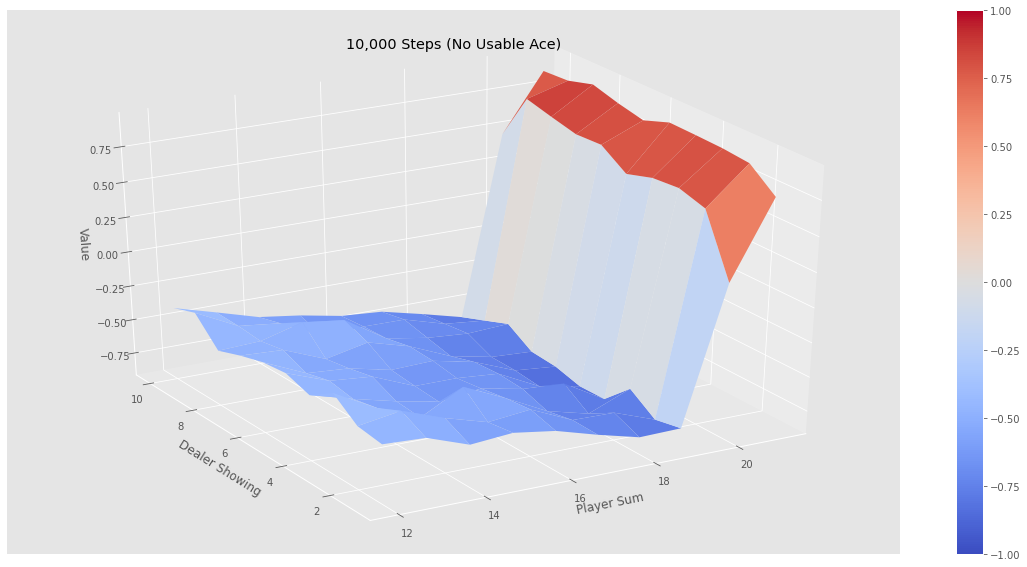

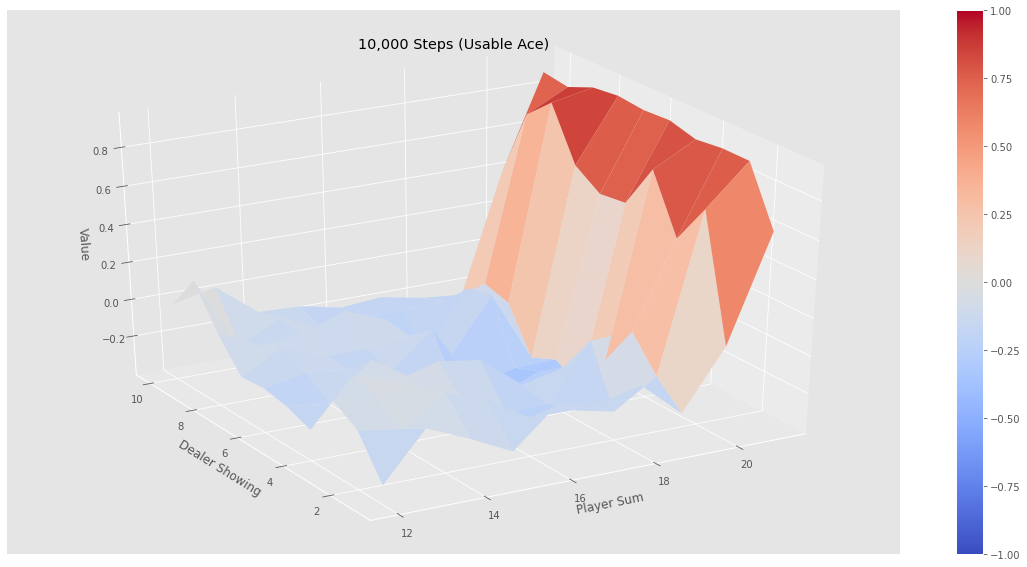


 1.9928970000000001 s
Episode 2000/500000.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Episode 500000/500000.

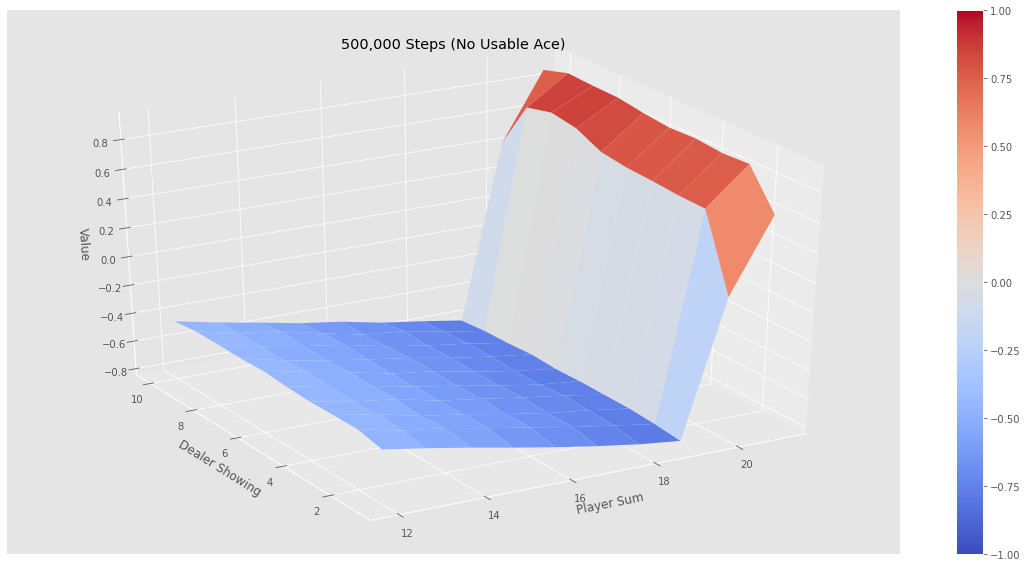

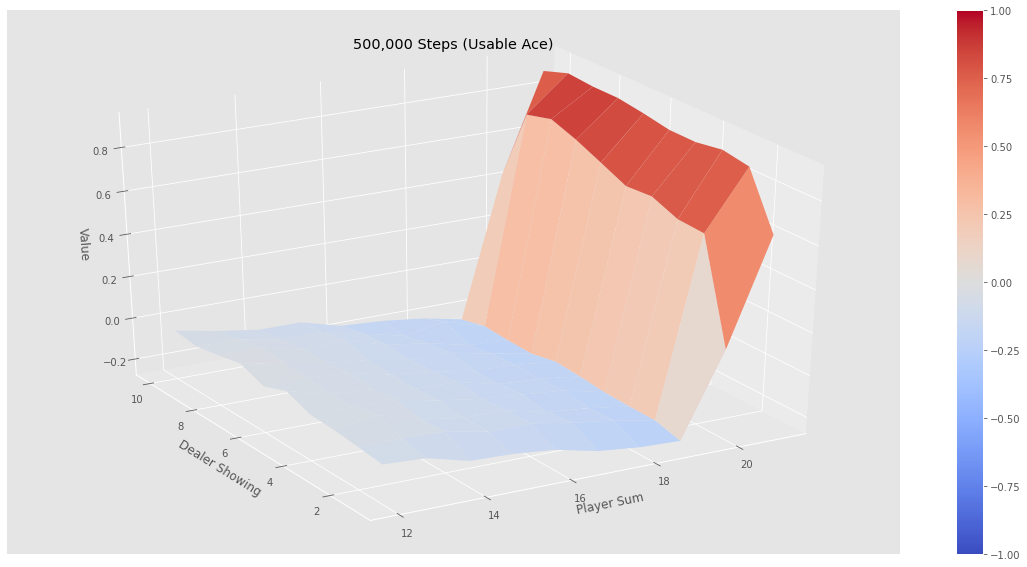


 49.306477 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
import gym
import matplotlib
import numpy as np
import sys
import time
from collections import defaultdict
# from blackjack import BlackjackEnv
# import plotting

%matplotlib inline
matplotlib.style.use('ggplot')

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    # The final value function
    V = defaultdict(float)
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurence of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurence
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V   

def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

if __name__ == '__main__':
    env = BlackjackEnv()
    # Plot value functions
    start = time.clock()
    V_10k = mc_prediction(sample_policy, env, num_episodes=10000,discount_factor=0.5)
    plot_value_function(V_10k, title="10,000 Steps")
    end = time.clock()
    print("\n",end - start,"s")
    start = time.clock()
    V_500k = mc_prediction(sample_policy, env, num_episodes=500000,discount_factor=0.5)
    plot_value_function(V_500k, title="500,000 Steps")
    end = time.clock()
    print("\n",end - start,"s")

Some notes:
*  Each episode is an array of tuples `(y1, y2, y3)` where `y1` is the state, `y2` is the action, `y3` is the reward
*  There are 100 steps (i.e. rounds) in each episode
*  The graph is best interpreted when the value function is very well approximated (after e.g. 500,000 steps)

What do we see in the graph?

Once the value function is well approximated (after e.g. 500,000 steps) we can see that the probability of a win is very high when the player's sum is 20 or 21. Two interesting characteristics of the return values exist at the ends of the Dealer Showing axis. If the Dealer Showing card has a value of 2 or less, or between 9 and 10, then the player's probability of a win decreases. This represents the case where the dealer's score is exactly 21.

### The Control Problem: On-policy First-visit Monte Carlo Control
The goal of the MC control problem is to determine the _optimal policy_ (a state-action pair) that maximises the reward function. This is done using an $\epsilon$-greedy approach, meaning that the agent chooses with probability $1-\epsilon$ the action that has the maximal estimated action value the majority of the time, but infrequently selects an action at random with probability $\epsilon$.

#### On-policy first-visit MC control in pseudocode
From Ch. 5.3: Monte Carlo Control (pp. 97-103) of R. Sutton's _Reinforcement Learning: An Introduction (2nd Edition)_. Link [here](http://www.incompleteideas.net/book/ebook/node53.html).
![On-policy first-visit MC control in pseudocode (R. Sutton, p.101).](https://docs.google.com/uc?export=download&id=1-feCF2mTmiJQk1XwQ5B6NQyFl4qpdANq)

In [ ]:
### From `Optimising Blackjack Strategy using Model-Free Learning` in Ang Peng Seng's `Blackjack Strategy using Reinforcement Learning`
# Credit: https://www.kaggle.com/angps95/blackjack-strategy-using-reinforcement-learning/notebook

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

In [ ]:
### From `MC_Control_with_Epsilon-Greedy_Policies.ipynb` in V.K.s `RL Exercise`
# Credit: github.com/dennybritz/reinforcement-learning/MC/

Episode 1000000/1000000.
 280.8933548927307 s


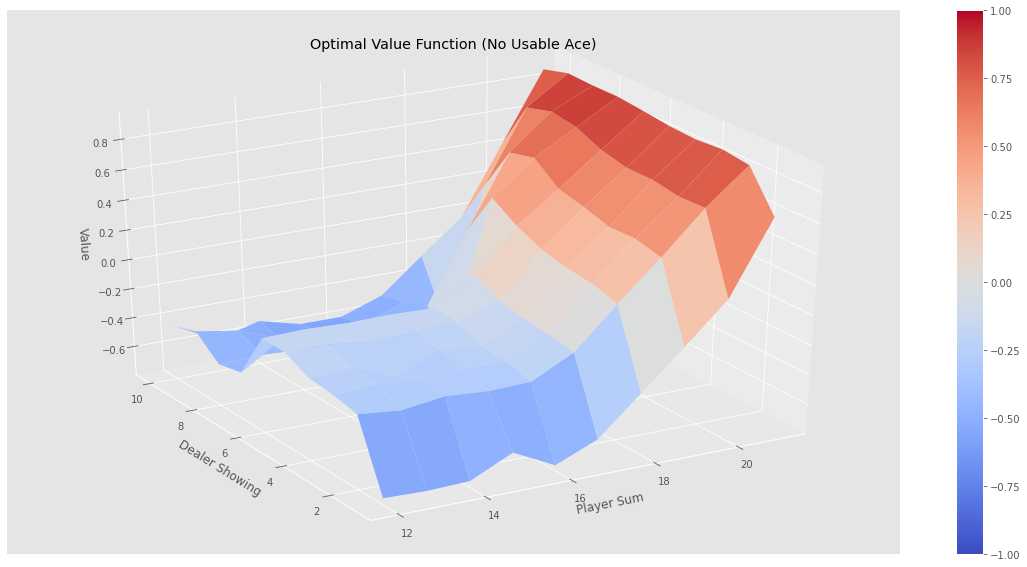

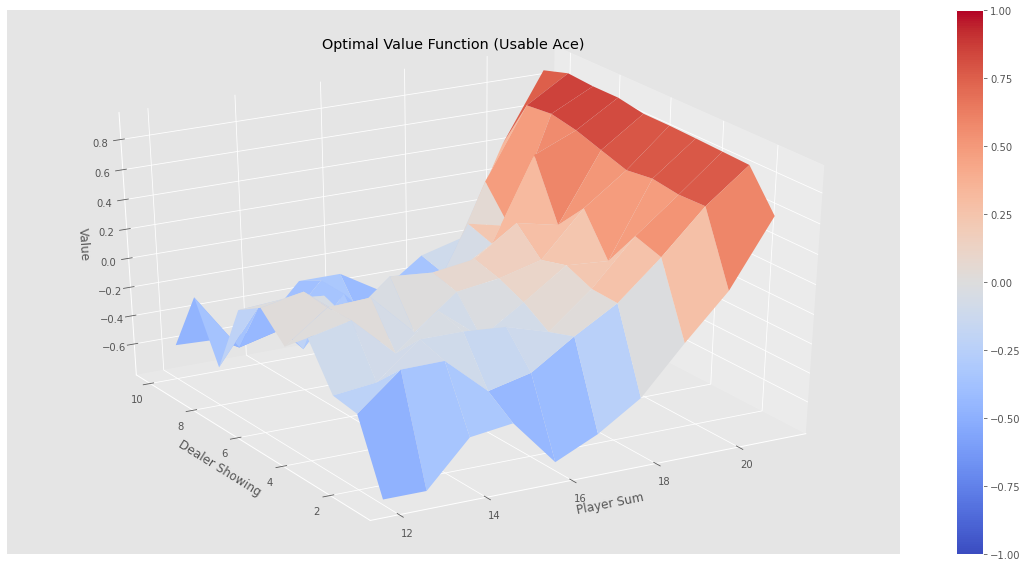

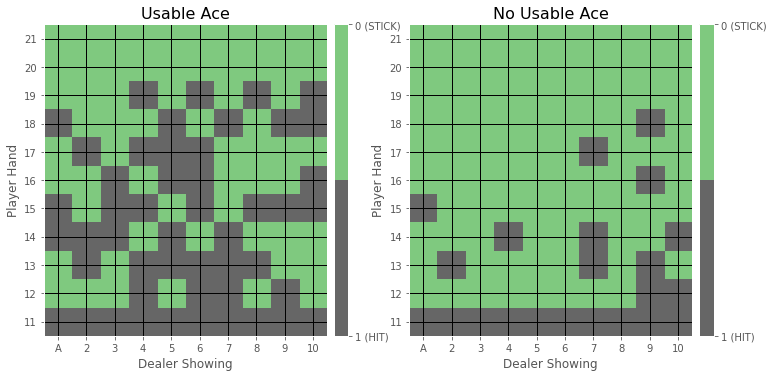

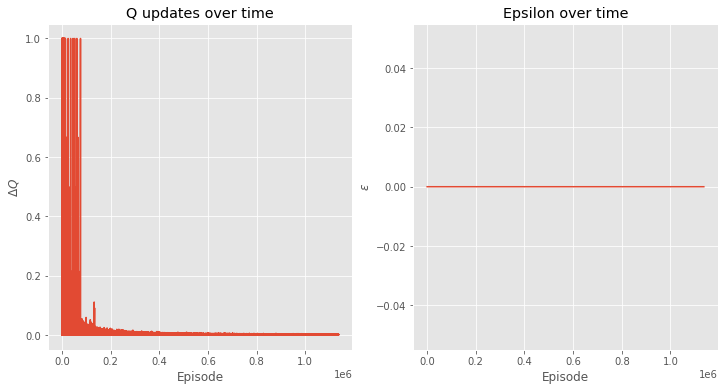

Number of policy improvement cycles:  1137042.0
Episode 1000000/1000000.
 302.9268114566803 s


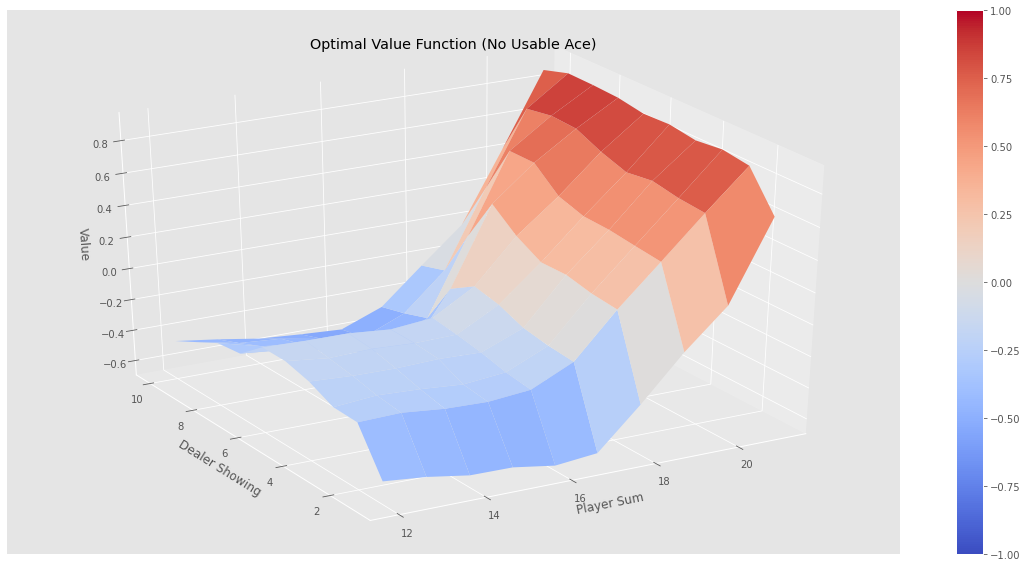

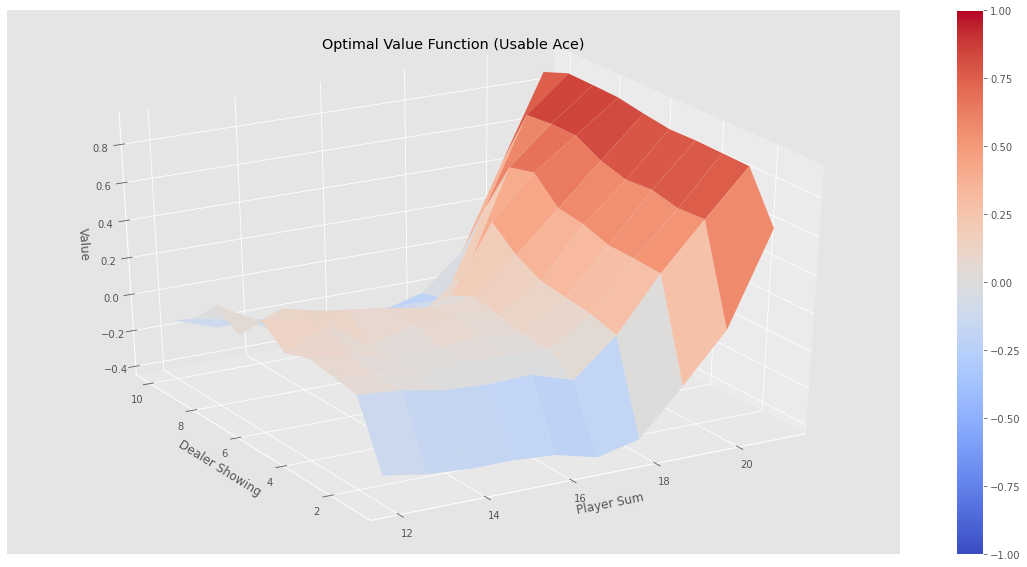

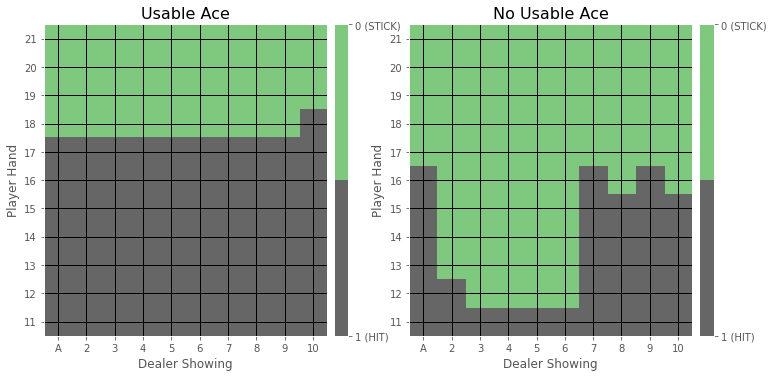

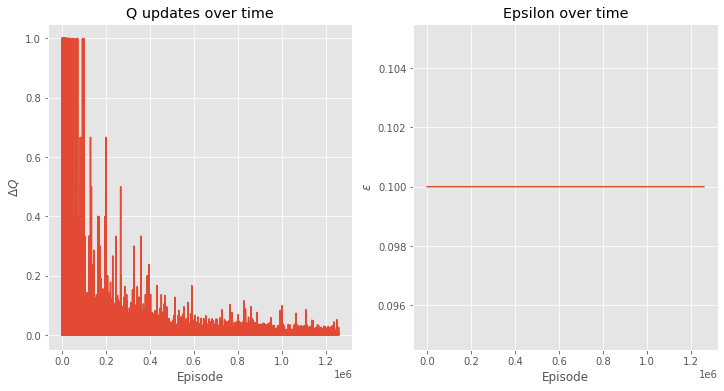

Number of policy improvement cycles:  1259603.0
Episode 1000000/1000000.
 294.7193982601166 s


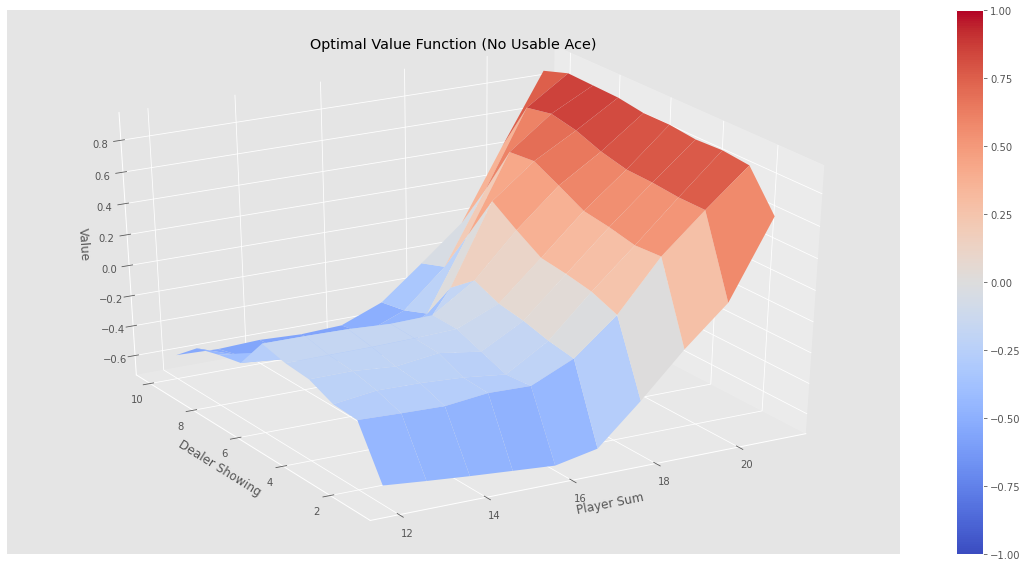

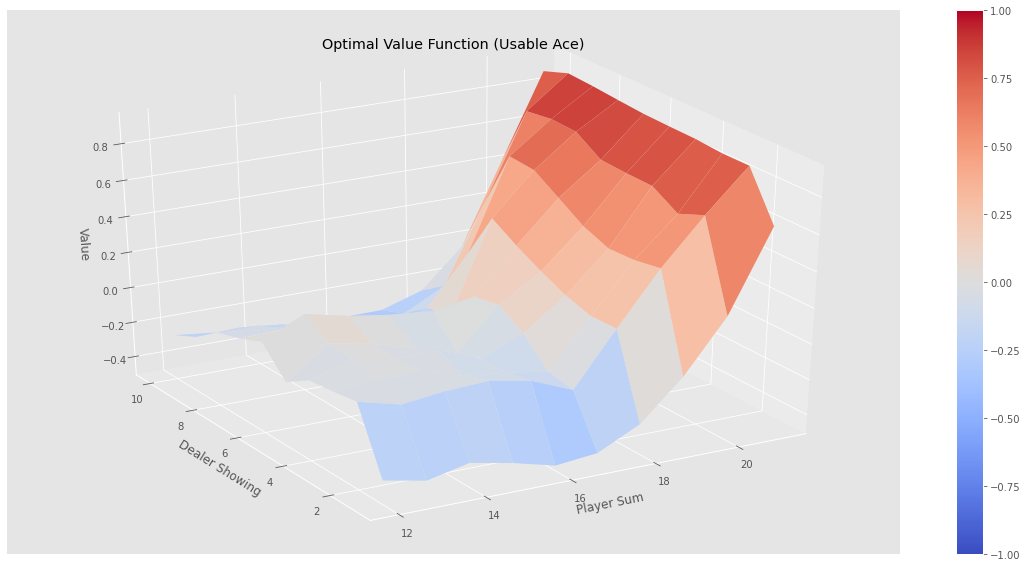

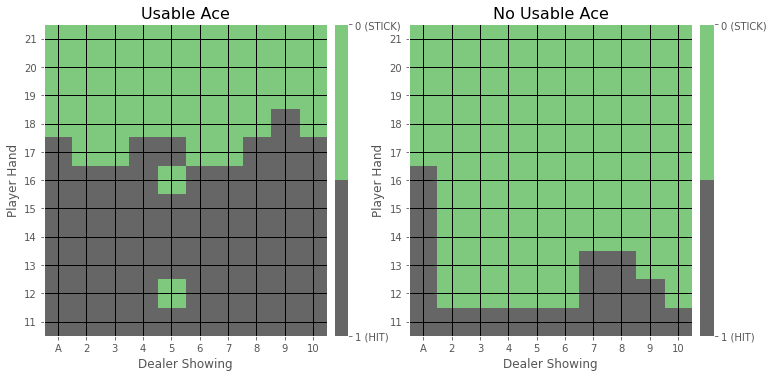

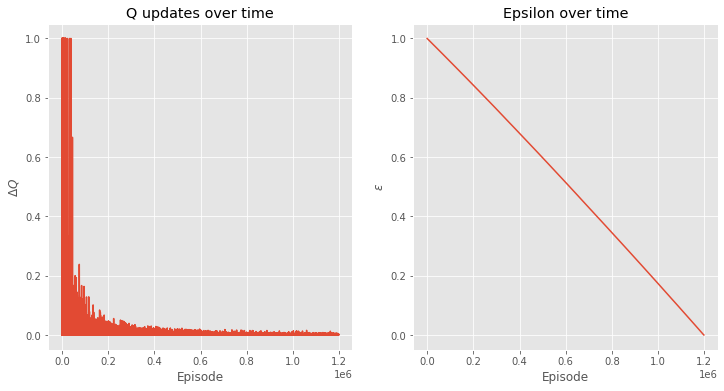

Number of policy improvement cycles:  1197783.0
Episode 1000000/1000000.
 296.48150062561035 s


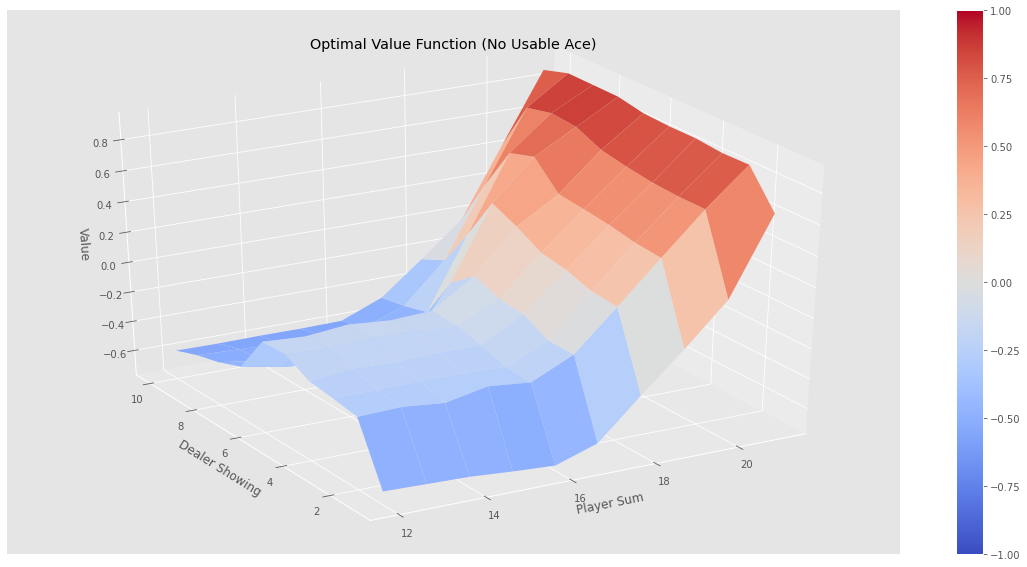

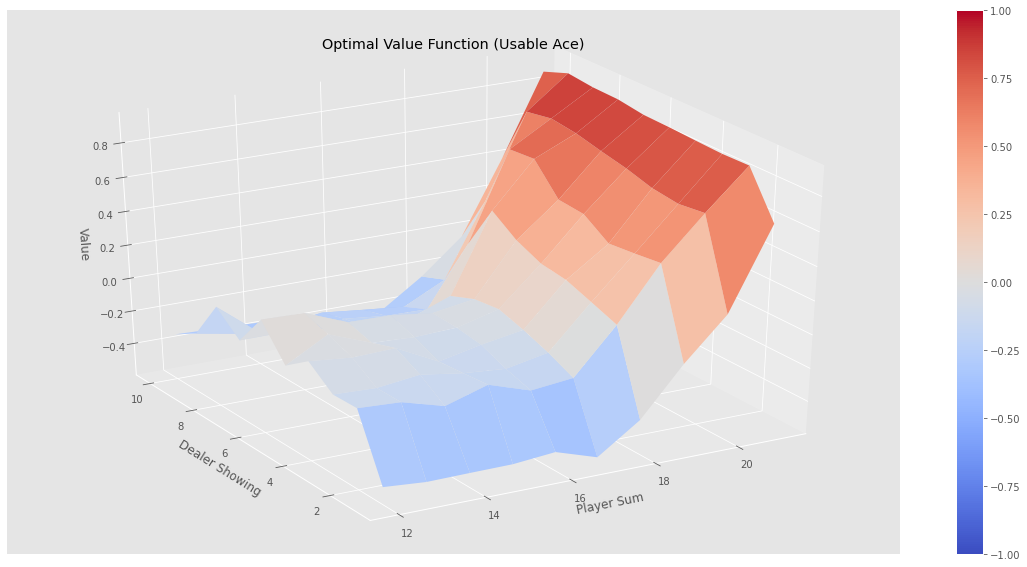

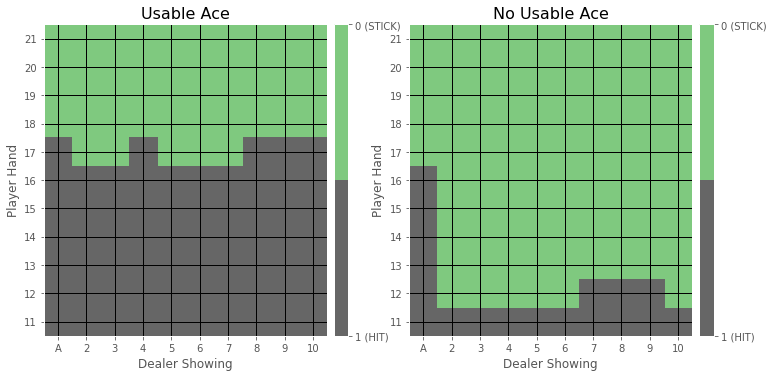

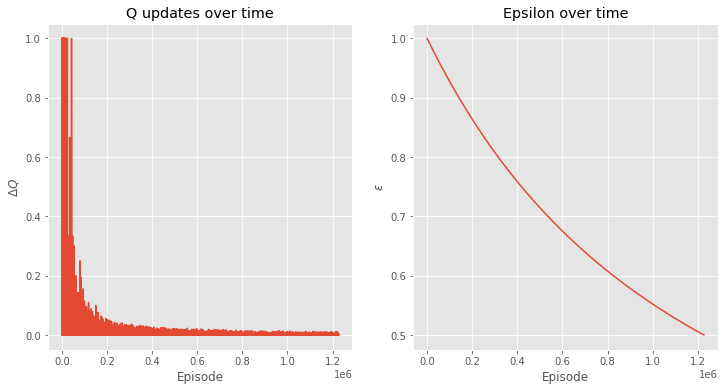

Number of policy improvement cycles:  1226697.0


In [ ]:
import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

matplotlib.style.use('ggplot')


class NoSchedule(object):
    def __init__(self, epsilon_initial=0.1):
        """
        The constant epsilon_initial value is returned at each timestep t. No 
        annealing is performed with this schedule.

        Args:
            epsilon_initial: The initial output value.
        
        Returns:
            The initial value of epsilon. Remains constant over time.
        """
        self.epsilon_initial = epsilon_initial
    def value(self, t):
        return self.epsilon_initial


class LinearSchedule(object):
    def __init__(self, annealing_steps, epsilon_final, epsilon_initial=1.0):
        """
        A linear interpolation between epsilon_initial and epsilon_final over
        schedule_timesteps. The epsilon_final value is returned after this many
        timesteps.

        Args:
            annealing_steps: Number of timesteps for which to linearly anneal
                epsilon_inital to epsilon_final.
            epsilon_final: The final output value.
            epsilon_initial: The initial output value.
        
        Returns:
            The value of epsilon annealed over time.
        """
        self.annealing_steps = annealing_steps
        self.epsilon_final = epsilon_final
        self.epsilon_initial = epsilon_initial
    def value(self, t):
        fraction = min(float(t) / self.annealing_steps, 1.0)
        return max(self.epsilon_initial + fraction * (self.epsilon_final - self.epsilon_initial), self.epsilon_final)


class TimeDecaySchedule(object):
        def __init__(self, annealing_steps, epsilon_final, epsilon_initial=1.0):
            """
            Args:
                annealing_steps: Number of timesteps for which to linearly anneal
                    epsilon_inital to epsilon_final.
                epsilon_final: The final output value.
                epsilon_initial: The initial output value.
            
            Returns:
                The value of epsilon annealed over time.
            """
            self.annealing_steps = annealing_steps
            self.epsilon_final = epsilon_final
            self.epsilon_initial = epsilon_initial
            self.decay_rate = epsilon_initial / annealing_steps
        def value(self, t):
            return self.epsilon_initial * (1.0 / (1.0 + self.decay_rate * t))


class BlackjackRL:
    def make_epsilon_greedy_policy(self, Q, epsilon, nA):
        """
        Creates an epsilon-greedy policy based on a given Q-function and epsilon.

        Args:
            Q: A dictionary that maps from state -> action-values.
                Each value is a numpy array of length nA (see below)
            epsilon: The probability to select a random action. 
                Float between 0 and 1.
            nA: Number of actions in the environment.

        Returns:
            A function that takes the observation and epsiode counter as arguments and returns
            the probabilities for each action in the form of a numpy array of length nA.
        """
        def policy_fn(observation):
            # Update annealed epsilon value according to Q-learning strategy
            self.epsilon = self.scheduler.value(self.episode_count)
            self.epsilons.append(self.epsilon)
            # Initialise all actions a in A with probability of exploration
            A = np.ones(shape=nA, dtype=np.float64) * self.epsilon / nA
            # The index of the best action given the current observation
            A_star = np.argmax(Q[observation])
            # Update probability of selecting best action
            A[A_star] += (1.0 - self.epsilon)
            return A
        return policy_fn

    def mc_control_epsilon_greedy(self, env, num_episodes, discount_factor=1.0, scheduler=None, tol=1e-4):
        """
        Monte Carlo Control using Epsilon-Greedy policies.
        Finds an optimal epsilon-greedy policy.

        Args:
            env: OpenAI gym environment.
            num_episodes: Number of episodes to sample.
            discount_factor: Gamma discount factor.
            scheduler: Function which performs annealing of epsilon.
            tol: The threshold at which Q stops changing significantly.
                Float between 0 and 1.
        
        Returns:
            A tuple (Q, policy, returns_count, deltas).
                Q is a dictionary mapping state -> action values.
                policy is a function that takes an observation as an argument and returns
                action probabilities.
                returns_count is a sum of all returns for each state.
                deltas is an array of values of Q_delta computed at each iteration.
        """
        # Keeps track of the current and past epsilon values
        self.epsilon = scheduler.epsilon_initial
        self.epsilons = []
        # Sets the number of episodes to sample and maintains a counter
        self.num_episodes = num_episodes
        self.episode_count = 0
        # Performs anealing of epsilon
        self.scheduler = scheduler
        # Keeps track of sum and count of returns for each state
        # to calculate an average. We could use an array to save all
        # returns (like in the book) but that's memory inefficient.
        returns_sum = defaultdict(float)
        returns_count = defaultdict(float)
        # Keep track of average returns per episode
        returns_avg = []
        rewards_avg = []
        # The final action-value function.
        # A nested dictionary that maps state -> (action -> action-value).
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
        # Keeps track of changes in Q values
        Q_delta = 1e-2
        deltas = []
        # The policy we're following
        policy = self.make_epsilon_greedy_policy(Q, self.epsilon, env.action_space.n)

        for i_episode in range(1, num_episodes + 1):
            """
            Halt learning if Q_delta stops changing significantly
            if Q_delta < tol:
                break
            """
            # Print out which episode we're on, useful for debugging.
            if i_episode % 1000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
                sys.stdout.flush()          
            # Generate an episode.
            # An episode is an array of (state, action, reward) tuples
            episode = []
            returns_episode = 0
            reward_sum = 0
            state = env.reset()
            for t in range(100):
                # Choose action randomly such that all pairs have probability > 0
                probs = policy(state)
                action = np.random.choice(np.arange(len(probs)), p=probs)
                # Generate an episode from state-action pair following policy
                next_state, reward, done, _ = env.step(action)
                episode.append((state, action, reward))
                reward_sum += reward
                if done:
                    # Calculate average reward for this episode
                    rewards_avg.append(reward_sum / (t + 1))
                    break
                state = next_state
            # Find all the state-action pairs that we've visited in this episode
            # We convert each state to a tuple so that we can use it as a dict key
            states_actions_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
            for state, action in states_actions_in_episode:
                pair = (state, action)
                # Find the first occurence of the state-action pair in the episode
                first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
                # Sum up all rewards since the first occurence
                G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
                # Calculate average return for this episode over all state-action pairs
                returns_episode += G
                # Calculate average return for this state-action pair over all sampled episodes
                returns_sum[pair] += G
                returns_count[pair] += 1.0
                # Compute change in Q value between iterations
                Q_prev = Q[state][action]
                Q_new = returns_sum[pair] / returns_count[pair]
                Q_delta = np.abs(Q_new - Q_prev)
                deltas.append(Q_delta)
                Q[state][action] = Q_new
            returns_avg.append(returns_episode / len(episode))
            self.episode_count += 1
            # The policy is improved implicitly by changing the Q dictionary
        return Q, policy, returns_count, deltas, rewards_avg, returns_avg


if __name__ == '__main__':
    env = BlackjackEnv()
    engine = BlackjackRL()
    rewards = []
    num_episodes = 1000000
    # Epsilon-greedy annealing schedules
    schedules = [NoSchedule(epsilon_initial=0.0),
                 NoSchedule(epsilon_initial=0.1),
                 LinearSchedule(annealing_steps=num_episodes, epsilon_final=0.0, epsilon_initial=1.0), 
                 TimeDecaySchedule(annealing_steps=num_episodes, epsilon_final=0.0, epsilon_initial=1.0)]
    for schedule in schedules:
        start = time.time()
        Q, policy, returns_count, deltas, rewards_avg, returns_avg = engine.mc_control_epsilon_greedy(env, num_episodes=num_episodes, scheduler=schedule)
        end = time.time()
        print("\n", end - start,"s")
        # For plotting: Create value function from action-value function
        # by picking the best action at each state
        V = defaultdict(float)
        for state, actions in Q.items():
            action_value = np.max(actions)
            V[state] = action_value
        plot_value_function(V, title="Optimal Value Function")
        on_policy = {key: np.argmax(policy(key)) for key in Q.keys()}
        plot_policy(on_policy)
        # Plotting instantaneous rate of change of Q values
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1,2,1)
        ax.plot(deltas)
        ax.set_title(r'Q updates over time')
        ax.set_xlabel("Episode")
        ax.set_ylabel(r'$\Delta Q$')
        # Plotting epsilon values over time
        ax = fig.add_subplot(1,2,2)
        ax.plot(engine.epsilons)
        ax.set_title("Epsilon over time")
        ax.set_xlabel("Episode")
        ax.set_ylabel(r'$\epsilon$')
        plt.show()
        # Number of policy iterations
        print("Number of policy improvement cycles: ", sum(returns_count.values()))
        rewards.append(rewards_avg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Cumulative average reward')

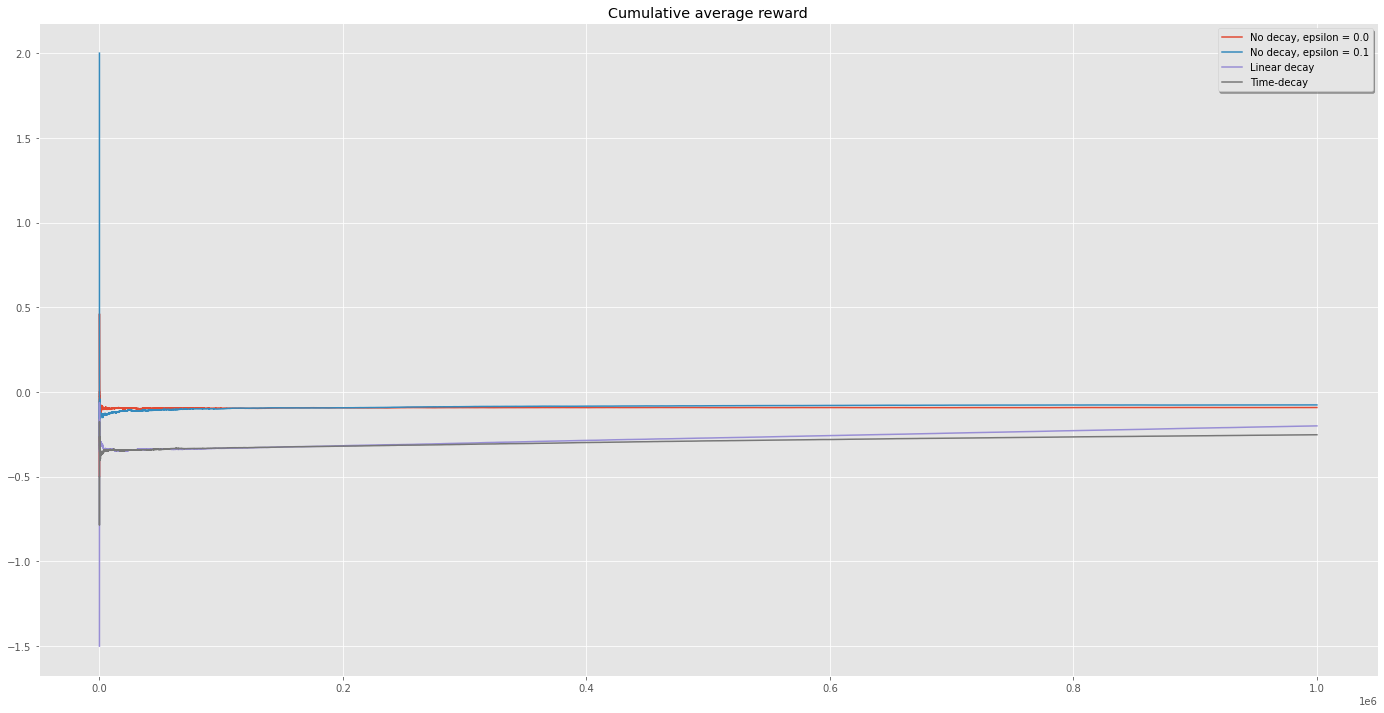

In [ ]:
# Plot cumulative average rewards for each schedule
fig = plt.figure(figsize=(24, 12))
for i, r in enumerate(rewards):
    plt.plot(np.arange(0, len(rewards[i])), np.cumsum(rewards[i]) / np.arange(len(rewards[i])))
    plt.plot()
plt.legend(labels=['No decay, epsilon = 0.0', 'No decay, epsilon = 0.1', 'Linear decay', 'Time-decay'], shadow=True)
plt.title('Cumulative average reward')

## Credits
This assignment was prepared by V. Krueger et al., HT2019 (link [here](https://web.archive.org/web/20200111075253/http://cs.lth.se/edan95/lab-programming-assignments/lab-session-7/)).

A great walk-through of First-visit Monte Carlo Prediction can be found on YouTube by Jareth Moyo (_Lecture 12: Playing Blackjack with Monte Carlo_, link [here](https://www.youtube.com/watch?v=3686U57JnLs)).

The majority of the code in this notebook has been reproduced from Denny Britz' `reinforcement-learning` repository (link [here](https://github.com/dennybritz/reinforcement-learning)).

The optimal policy plotting function was written by Ang Peng Seng (link [here](https://www.kaggle.com/angps95/blackjack-strategy-using-reinforcement-learning/notebook)).

Implementation of linear annealing strategy can be found [here](https://nbviewer.org/urls/www.ccs.neu.edu/home/rplatt/cs7180_fall2018/assignments/cs7180-hw6-dqn.ipynb). Other common annealing schedules which are often used for learning rate annealing can be found in the Keras codebase (link [here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py)).
